# Objective

Predict if a property is a good investment based on financial and physical attributes.

<b>Target:</b>

A binary variable indicating good (1) or bad (0) investment. Define this based on criteria such as a high rent-to-price ratio or a favorable market estimate compared to the listed price.


In [21]:
import pandas as pd

# Data exploration


In [22]:
real_estate_data = pd.read_csv("./data/real_estate_data.csv")
real_estate_data.describe()

# Find any missing data in the dataset.
missing_values = real_estate_data.isnull().sum()

missing_values

State                0
City                 0
Street               0
Zipcode              0
Bedroom             14
Bathroom            34
Area                 0
PPSq                 0
LotArea            902
MarketEstimate    7236
RentEstimate      5976
Latitude             0
Longitude            0
ListedPrice          0
dtype: int64

In [23]:
# See how much data there is with no null values. This can help us determine if we can simply remove all of the nulls from the dataset.

len(real_estate_data.dropna()), real_estate_data.dropna().isnull().sum()

(14853,
 State             0
 City              0
 Street            0
 Zipcode           0
 Bedroom           0
 Bathroom          0
 Area              0
 PPSq              0
 LotArea           0
 MarketEstimate    0
 RentEstimate      0
 Latitude          0
 Longitude         0
 ListedPrice       0
 dtype: int64)

In [24]:
# Get the average difference of List to Estimate by state.

no_null_market_estimate = real_estate_data[real_estate_data["MarketEstimate"].notnull()]

avg_market_minus_list = (
    real_estate_data["MarketEstimate"] - real_estate_data["ListedPrice"]
).median()
avg_market_minus_list

-1600.0

# Data preprocessing


In [25]:
# Remove all rows without a Rent Estimate as this value is vital to my analysis.

real_estate_data = real_estate_data[real_estate_data["RentEstimate"].notnull()]

len(real_estate_data), real_estate_data.isnull().sum()

(16705,
 State                0
 City                 0
 Street               0
 Zipcode              0
 Bedroom              9
 Bathroom            24
 Area                 0
 PPSq                 0
 LotArea            611
 MarketEstimate    1308
 RentEstimate         0
 Latitude             0
 Longitude            0
 ListedPrice          0
 dtype: int64)

In [26]:
# Update market estimates with the average difference between
for index, row in real_estate_data.iterrows():
    if pd.isna(row["MarketEstimate"]):
        real_estate_data.at[index, "MarketEstimate"] = (
            row["ListedPrice"] + avg_market_minus_list
        )

real_estate_data.isnull().sum()

State               0
City                0
Street              0
Zipcode             0
Bedroom             9
Bathroom           24
Area                0
PPSq                0
LotArea           611
MarketEstimate      0
RentEstimate        0
Latitude            0
Longitude           0
ListedPrice         0
dtype: int64

In [27]:
# Populate bed, bath, and lot area based on the median area for the given state.


def get_median_for_row(row: pd.Series, df: pd.DataFrame, area_offset=200):
    area = row["Area"]
    filtered_df = df[df["State"].eq(row["State"])].query(
        f"Area <= {area + area_offset} or Area >= {area - area_offset}"
    )
    median_bed = filtered_df["Bedroom"].median()
    median_bath = filtered_df["Bathroom"].median()
    median_lot = filtered_df["LotArea"].median()
    return median_bed, median_bath, median_lot


for index, row in real_estate_data.iterrows():
    if pd.isna(row["Bedroom"]) or pd.isna(row["Bathroom"]) or pd.isna(row["LotArea"]):
        if pd.isna(row["Bedroom"]):
            median_bed, _, _ = get_median_for_row(row, real_estate_data)
            real_estate_data.at[index, "Bedroom"] = median_bed
        if pd.isna(row["Bathroom"]):
            _, median_bath, _ = get_median_for_row(row, real_estate_data)
            real_estate_data.at[index, "Bathroom"] = median_bath
        if pd.isna(row["LotArea"]):
            _, _, median_lot = get_median_for_row(row, real_estate_data)
            real_estate_data.at[index, "LotArea"] = median_lot

real_estate_data.isnull().sum()

State             0
City              0
Street            0
Zipcode           0
Bedroom           0
Bathroom          0
Area              0
PPSq              0
LotArea           0
MarketEstimate    0
RentEstimate      0
Latitude          0
Longitude         0
ListedPrice       0
dtype: int64

In [28]:
# Convert zipcodes to string data as the number representation does not provide much value.


def zip_to_zip_str(numeric_zip: float):
    rounded_zip = int(numeric_zip)
    return str(rounded_zip).zfill(5)


real_estate_data["Zipcode"] = real_estate_data["Zipcode"].apply(zip_to_zip_str)

real_estate_data["Zipcode"].unique()

array(['36571', '35043', '35811', ..., '82649', '83112', '82932'],
      dtype=object)

In [29]:
from src.const import property_tax_rates

# Calculating the additional features:

real_estate_data["AnnualPropertyTaxEstimate"] = real_estate_data[
    "MarketEstimate"
] * real_estate_data["State"].map(property_tax_rates)


# Estimated Monthly Mortgage - assuming a 30-year fixed mortgage at 6% interest rate.
interest_rate = 0.06 / 12
loan_term = 30 * 12  # 30 years fixed rate loan.
real_estate_data["MonthlyMortgageEstimate"] = (
    real_estate_data["ListedPrice"] * interest_rate * (1 + interest_rate) ** loan_term
) / ((1 + interest_rate) ** loan_term - 1)

real_estate_data[
    [
        "ListedPrice",
        "MarketEstimate",
        "RentEstimate",
        "AnnualPropertyTaxEstimate",
        "MonthlyMortgageEstimate",
    ]
].head()

,ListedPrice,MarketEstimate,RentEstimate,AnnualPropertyTaxEstimate,MonthlyMortgageEstimate
0,239900.0,240600.0,1599.0,986.46,1438.321710
3,335000.0,336200.0,1932.0,1378.42,2008.494259
4,250000.0,222700.0,1679.0,913.07,1498.876313
5,151000.0,150500.0,1385.0,617.05,905.321293
6,239000.0,238400.0,2125.0,977.44,1432.925755


In [30]:
# For this exercise I am going to populate the "GoodInvestment" field with 1 when the Rent price exceeds the annual cost of the home.

real_estate_data["AnnualCost"] = (
    real_estate_data["MonthlyMortgageEstimate"] * 12
) + real_estate_data["AnnualPropertyTaxEstimate"]
real_estate_data["AnnualIncome"] = real_estate_data["RentEstimate"] * 12

real_estate_data["GoodInvestment"] = real_estate_data.apply(
    lambda row: 1 if row["AnnualIncome"] > row["AnnualCost"] else 0, axis=1
)

len(real_estate_data), real_estate_data["GoodInvestment"].value_counts()

(16705,
 GoodInvestment
 0    10523
 1     6182
 Name: count, dtype: int64)

In [31]:
# Create function which creates testing and training data drops fields that should not be included in the analysis

from sklearn.model_selection import train_test_split

DEFAULT_DROP_FIELDS = [
    "GoodInvestment",
    "AnnualCost",
    "AnnualIncome",
    "RentEstimate",
    "MonthlyMortgageEstimate",
    "AnnualPropertyTaxEstimate",
]


def train_test(
    df: pd.DataFrame,
    drop_fields=DEFAULT_DROP_FIELDS,
):
    if drop_fields is None:
        drop_fields = DEFAULT_DROP_FIELDS

    X = df.drop(drop_fields, axis=1)

    y = df["GoodInvestment"]

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree


In [32]:
# Decisions trees sometimes perform better when continuous data data is binned. We will bin values like areas, beds, bathrooms, and prices.

area_bins = [
    0,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    5000,
    7500,
    10000,
    real_estate_data["Area"].max() + 1,
]
area_labels = [
    "0-1000 sqft",
    "1000-1500 sqft",
    "1500-2000 sqft",
    "2000-2500 sqft",
    "2500-3000 sqft",
    "3000-3500 sqft",
    "3500-4000 sqft",
    "4000-5000 sqft",
    "5000-7500 sqft",
    "7500-10000 sqft",
    "10000+ sqft",
]

price_bins = [
    0,
    150_000,
    200_000,
    250_000,
    300_000,
    350_000,
    400_000,
    450_000,
    500_000,
    600_000,
    750_000,
    1_000_000,
    2_500_000,
    5_000_000,
    10_000_000,
    real_estate_data["ListedPrice"].max() + 1,
]
price_labels = [
    "0-150k",
    "150k-200k",
    "200k-250k",
    "250k-300k",
    "300k-350k",
    "350k-400k",
    "400k-450k",
    "450k-500k",
    "500k-600k",
    "600k-750k",
    "750k-1m",
    "1m-2m",
    "2.5m-5m",
    "5m-10m",
    "10m+",
]

lot_bins = [
    0,
    0.11,
    0.17,
    0.23,
    0.35,
    0.5,
    1,
    1.5,
    3,
    10,
    real_estate_data["LotArea"].max() + 1,
]
lot_labels = [
    "0-0.11 acres",
    "0.11-0.17 acres",
    "0.17-0.23 acres",
    "0.23-0.35 acres",
    "0.35-0.5 acres",
    "0.5-1 acres",
    "1-1.5 acres",
    "1.5-3 acres",
    "3-10 acres",
    "10+ acres",
]

bed_bins = [0] + real_estate_data["Bathroom"].sort_values().unique()
bed_labels = [str(bed) for bed in bed_bins]
bed_labels.pop(0)

bath_bins = [0] + real_estate_data["Bedroom"].sort_values().unique()
bath_labels = [str(bath) for bath in bath_bins]
bath_labels.pop(0)

price_bins, price_labels, area_bins, area_labels, lot_bins, lot_labels, bed_bins, bed_labels, bath_bins, bath_labels

([0,
  150000,
  200000,
  250000,
  300000,
  350000,
  400000,
  450000,
  500000,
  600000,
  750000,
  1000000,
  2500000,
  5000000,
  10000000,
  76000001.0],
 ['0-150k',
  '150k-200k',
  '200k-250k',
  '250k-300k',
  '300k-350k',
  '350k-400k',
  '400k-450k',
  '450k-500k',
  '500k-600k',
  '600k-750k',
  '750k-1m',
  '1m-2m',
  '2.5m-5m',
  '5m-10m',
  '10m+'],
 [0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 7500, 10000, 99991.0],
 ['0-1000 sqft',
  '1000-1500 sqft',
  '1500-2000 sqft',
  '2000-2500 sqft',
  '2500-3000 sqft',
  '3000-3500 sqft',
  '3500-4000 sqft',
  '4000-5000 sqft',
  '5000-7500 sqft',
  '7500-10000 sqft',
  '10000+ sqft'],
 [0, 0.11, 0.17, 0.23, 0.35, 0.5, 1, 1.5, 3, 10, 701.0],
 ['0-0.11 acres',
  '0.11-0.17 acres',
  '0.17-0.23 acres',
  '0.23-0.35 acres',
  '0.35-0.5 acres',
  '0.5-1 acres',
  '1-1.5 acres',
  '1.5-3 acres',
  '3-10 acres',
  '10+ acres'],
 array([ 0.        ,  0.75      ,  1.        ,  1.10000002,  1.20000005,
         1.5       ,  

### Create the dataset


In [33]:
# Dataset A: No binning at all.

STRING_FIELDS = ["State", "City", "Zipcode", "Street"]

data_a = pd.get_dummies(real_estate_data, columns=STRING_FIELDS)

In [34]:
# Dataset B: Use all bins.

data_b = real_estate_data.copy()

data_b["ListedPrice_Binned"] = pd.cut(
    data_b["ListedPrice"], bins=price_bins, labels=price_labels
)
data_b["Area_Binned"] = pd.cut(data_b["Area"], bins=area_bins, labels=area_labels)
data_b["Bedroom_Binned"] = pd.cut(data_b["Bedroom"], bins=bed_bins, labels=bed_labels)
data_b["Bathroom_Binned"] = pd.cut(
    data_b["Bathroom"], bins=bath_bins, labels=bath_labels
)
data_b["LotArea_Binned"] = pd.cut(data_b["LotArea"], bins=lot_bins, labels=lot_labels)

data_b = pd.get_dummies(
    data_b.drop(["ListedPrice", "Area", "Bathroom", "Bedroom", "LotArea"], axis=1),
    columns=STRING_FIELDS
    + [
        "ListedPrice_Binned",
        "Area_Binned",
        "Bedroom_Binned",
        "Bathroom_Binned",
        "LotArea_Binned",
    ],
)

In [35]:
# Dataset C: Area binned only.

data_c = real_estate_data.copy()

data_c["Area_Binned"] = pd.cut(data_c["Area"], bins=area_bins, labels=area_labels)
data_c["LotArea_Binned"] = pd.cut(data_c["LotArea"], bins=lot_bins, labels=lot_labels)

data_c = pd.get_dummies(
    data_c.drop(["Area", "LotArea"], axis=1),
    columns=STRING_FIELDS + ["Area_Binned", "LotArea_Binned"],
)

In [36]:
# Dataset D: Only price binned.

data_d = real_estate_data.copy()

data_d["ListedPrice_Binned"] = pd.cut(
    data_d["ListedPrice"], bins=price_bins, labels=price_labels
)

data_d = pd.get_dummies(
    data_d.drop(["ListedPrice"], axis=1), columns=STRING_FIELDS + ["ListedPrice_Binned"]
)

### Train the models with the gini index as the splitting criteria


In [37]:
from typing import Literal
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor, as_completed

# Train the decision tree on all of the datasets and compare the accuracy.


def train_and_evaluate(
    data: pd.DateOffset,
    drop_fields=None,
    criterion: Literal["gini", "entropy", "log_loss"] = "gini",
):
    X_train, X_test, y_train, y_test = train_test(data, drop_fields=drop_fields)

    model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


(
    f"Dataset A accuracy: {train_and_evaluate(data_a)}",
    f"Dataset B accuracy: {train_and_evaluate(data_b)}",
    f"Dataset C accuracy: {train_and_evaluate(data_c)}",
    f"Dataset D accuracy: {train_and_evaluate(data_d)}",
)

('Dataset A accuracy: 0.8263992816521999',
 'Dataset B accuracy: 0.8159233762346603',
 'Dataset C accuracy: 0.8207123615683927',
 'Dataset D accuracy: 0.8159233762346603')

### Train the models with information gain as the splitting criteria


In [38]:
(
    f"Dataset A accuracy: {train_and_evaluate(data_a, criterion='entropy')}",
    f"Dataset B accuracy: {train_and_evaluate(data_b, criterion='entropy')}",
    f"Dataset C accuracy: {train_and_evaluate(data_c, criterion='entropy')}",
    f"Dataset D accuracy: {train_and_evaluate(data_d, criterion='entropy')}",
)

('Dataset A accuracy: 0.8045495360670458',
 'Dataset B accuracy: 0.8042502244836875',
 'Dataset C accuracy: 0.8075426519006286',
 'Dataset D accuracy: 0.798263992816522')

### Try removing some features to see if they are causing "noise" to the model. Use gini because it performed the best.


In [39]:
without_any_string_fields = real_estate_data.drop(
    ["State", "City", "Zipcode", "Street"], axis=1
)

f"Accuracy without long and lat: {train_and_evaluate(without_any_string_fields)}"

'Accuracy without long and lat: 0.789583956899132'

In [40]:
without_zip_code = pd.get_dummies(
    real_estate_data.drop(["Zipcode"], axis=1),
    columns=["State", "City", "Street"],
)

f"Accuracy without street: {train_and_evaluate(without_zip_code)}"

'Accuracy without street: 0.8231068542352589'

In [41]:
without_street = pd.get_dummies(
    real_estate_data.drop(["Street", "Zipcode"], axis=1),
    columns=["State", "City"],
)

f"Accuracy without street and zipcode: {train_and_evaluate(without_street)}"

'Accuracy without street and zipcode: 0.8192158036516013'

In [42]:
without_street_and_zipcode = pd.get_dummies(
    real_estate_data.drop(["Street"], axis=1),
    columns=["State", "City"],
)

f"Accuracy without zipcode: {train_and_evaluate(without_street_and_zipcode)}"

'Accuracy without zipcode: 0.8120323256510027'

In [43]:
without_logitude_and_latitude = data_a.drop(["Longitude", "Latitude"], axis=1)

f"Accuracy without long and lat: {train_and_evaluate(without_logitude_and_latitude)}"

'Accuracy without long and lat: 0.8030529781502544'

### See if the decision tree model can find my formula if the rent price is included.


In [44]:
f"Dataset a but with rent estimate: {train_and_evaluate(data_a, drop_fields=['GoodInvestment','AnnualCost','AnnualIncome','MonthlyMortgageEstimate','AnnualPropertyTaxEstimate',])}"

'Dataset a but with rent estimate: 0.9401376833283448'

In [45]:
f"Dataset a but with all fields (except the test field): {train_and_evaluate(data_a, drop_fields=['GoodInvestment'])}"

'Dataset a but with all fields (except the test field): 0.9796468123316372'

### Hypertune parameters


In [46]:
from sklearn.model_selection import GridSearchCV

X_train, _, y_train, _ = train_test(data_a)

param_grid = {
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 3, 4, 8],
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy"
)

best_model = grid_search.fit(X_train, y_train)

f"Best hyperparameters: {best_model.best_params_}, accuracy: {best_model.best_score_}"

"Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}, accuracy: 0.8217588952286224"

# Neural network


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = real_estate_data.drop("GoodInvestment", axis=1)
y = real_estate_data["GoodInvestment"]

numerical_features = [
    "Bedroom",
    "Bathroom",
    "Area",
    "PPSq",
    "LotArea",
    "MarketEstimate",
    "RentEstimate",
    "Latitude",
    "Longitude",
    "ListedPrice",
]
categorical_features = ["State", "City", "Street", "Zipcode"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
f"Test Accuracy: {accuracy}"

Epoch 1/10
418/418 [==============================] - 1s 2ms/step - loss: 0.3785 - accuracy: 0.8338
Epoch 2/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9653
Epoch 3/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0234 - accuracy: 0.9942
Epoch 4/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9978
Epoch 5/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0087 - accuracy: 0.9978
Epoch 6/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0076 - accuracy: 0.9975
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 0.9985
Epoch 8/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0058 - accuracy: 0.9983
Epoch 9/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0041 - accuracy: 0.9988
Epoch 10/10
105/105 [==============================] - 0s 722us/step - loss: 0.3542 - accuracy: 0.89

'Test Accuracy: 0.8979347348213196'

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score


def create_model(learning_rate=0.001, n_layers=1, n_nodes=32, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(n_nodes, activation="relu", input_shape=(X_train.shape[1],)))
    for _ in range(n_layers - 1):
        model.add(Dense(n_nodes, activation="relu"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


learning_rates = [0.001, 0.01]
n_layers = [1, 2, 3]
n_nodes = [32, 64]
dropout_rates = [0.0, 0.2]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for layers in n_layers:
        for nodes in n_nodes:
            for dropout in dropout_rates:
                model = create_model(
                    learning_rate=lr,
                    n_layers=layers,
                    n_nodes=nodes,
                    dropout_rate=dropout,
                )
                model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
                accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
                print(
                    f"lr: {lr}, layers: {layers}, nodes: {nodes}, dropout: {dropout}, accuracy: {accuracy}"
                )
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        "learning_rate": lr,
                        "n_layers": layers,
                        "n_nodes": nodes,
                        "dropout_rate": dropout,
                    }

(f"Best Accuracy: {best_accuracy}", f"Best Parameters: {best_params}")

lr: 0.001, layers: 1, nodes: 32, dropout: 0.0, accuracy: 0.8814725875854492
lr: 0.001, layers: 1, nodes: 32, dropout: 0.2, accuracy: 0.8850643634796143
lr: 0.001, layers: 1, nodes: 64, dropout: 0.0, accuracy: 0.8895540237426758
lr: 0.001, layers: 1, nodes: 64, dropout: 0.2, accuracy: 0.883867084980011
lr: 0.001, layers: 2, nodes: 32, dropout: 0.0, accuracy: 0.8919485211372375
lr: 0.001, layers: 2, nodes: 32, dropout: 0.2, accuracy: 0.893145740032196
lr: 0.001, layers: 2, nodes: 64, dropout: 0.0, accuracy: 0.8910505771636963
lr: 0.001, layers: 2, nodes: 64, dropout: 0.2, accuracy: 0.8913499116897583
lr: 0.001, layers: 3, nodes: 32, dropout: 0.0, accuracy: 0.8991320133209229
lr: 0.001, layers: 3, nodes: 32, dropout: 0.2, accuracy: 0.887458860874176
lr: 0.001, layers: 3, nodes: 64, dropout: 0.0, accuracy: 0.8934450745582581
lr: 0.001, layers: 3, nodes: 64, dropout: 0.2, accuracy: 0.8883568048477173
lr: 0.01, layers: 1, nodes: 32, dropout: 0.0, accuracy: 0.886860191822052
lr: 0.01, layers:

('Best Accuracy: 0.8991320133209229',
 "Best Parameters: {'learning_rate': 0.001, 'n_layers': 3, 'n_nodes': 32, 'dropout_rate': 0.0}")

Epoch 1/10
418/418 [==============================] - 1s 2ms/step - loss: 0.3747 - accuracy: 0.8346 - val_loss: 0.2587 - val_accuracy: 0.8869
Epoch 2/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.9681 - val_loss: 0.2742 - val_accuracy: 0.8899
Epoch 3/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.2941 - val_accuracy: 0.8934
Epoch 4/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.3019 - val_accuracy: 0.8949
Epoch 5/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.3200 - val_accuracy: 0.8931
Epoch 6/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.3508 - val_accuracy: 0.8937
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.3429 - val_accuracy: 0.8896
Epoch 

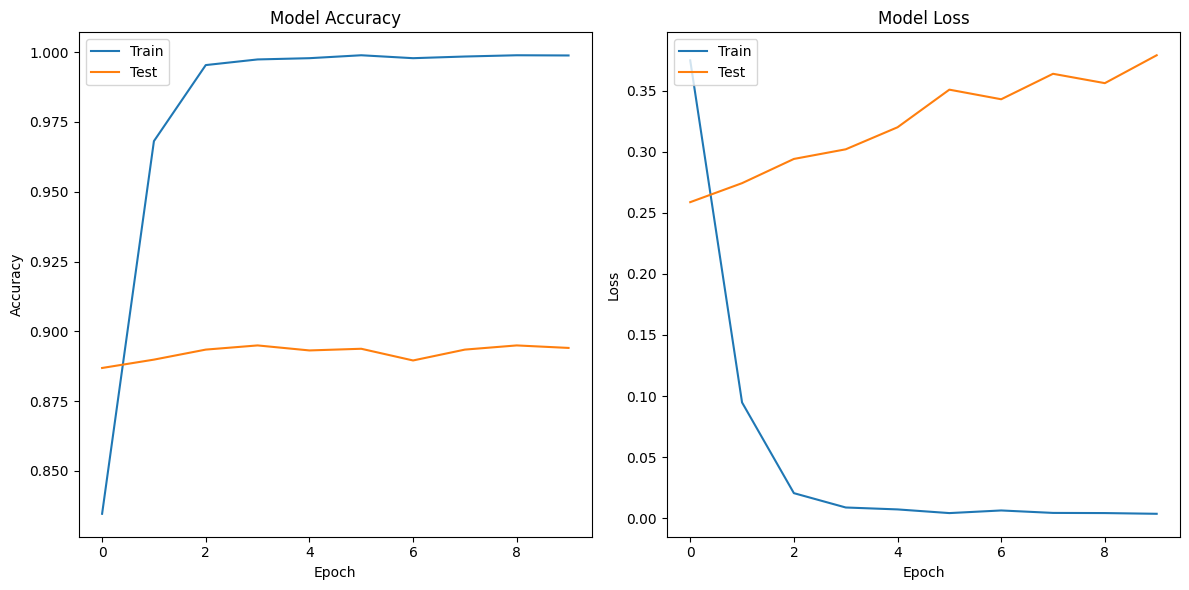

In [49]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam


model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

plt.tight_layout()
plt.show()

In [50]:
train_scores = history.history["accuracy"]
val_scores = history.history["val_accuracy"]

print("Epoch | Training Score | Validation Score")
print("-----------------------------------------")
for epoch in range(len(train_scores)):
    print(f"{epoch + 1}     | {train_scores[epoch]}         | {val_scores[epoch]}")

Epoch | Training Score | Validation Score
-----------------------------------------
1     | 0.8346303701400757         | 0.886860191822052
2     | 0.9681233167648315         | 0.8898533582687378
3     | 0.9953606724739075         | 0.8934450745582581
4     | 0.9973810315132141         | 0.8949416279792786
5     | 0.9978299736976624         | 0.893145740032196
6     | 0.9988775849342346         | 0.8937444090843201
7     | 0.9978299736976624         | 0.8895540237426758
8     | 0.9984286427497864         | 0.8934450745582581
9     | 0.9988775849342346         | 0.8949416279792786
10     | 0.9988027811050415         | 0.8940436840057373


In [52]:
# Extracting loss values
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Printing the loss values for each epoch
print("Epoch | Training Loss | Validation Loss")
print("---------------------------------------")
for epoch in range(len(train_loss)):
    print(f"{epoch + 1}     | {train_loss[epoch]:.4f}        | {val_loss[epoch]:.4f}")

Epoch | Training Loss | Validation Loss
---------------------------------------
1     | 0.3747        | 0.2587
2     | 0.0948        | 0.2742
3     | 0.0206        | 0.2941
4     | 0.0089        | 0.3019
5     | 0.0073        | 0.3200
6     | 0.0043        | 0.3508
7     | 0.0064        | 0.3429
8     | 0.0044        | 0.3637
9     | 0.0043        | 0.3561
10     | 0.0037        | 0.3789


In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

f"Test accuracy: {test_accuracy:.4f}"

105/105 - 0s - loss: 0.3789 - accuracy: 0.8940 - 79ms/epoch - 751us/step


'Test accuracy: 0.8940'

## Boosted decision tree


In [58]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test(data_a)

gbc = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42
)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8377731218198144
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2083
           1       0.78      0.79      0.79      1258

    accuracy                           0.84      3341
   macro avg       0.83      0.83      0.83      3341
weighted avg       0.84      0.84      0.84      3341



In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 4, 5],
}

gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
f"Best parameters: {grid_search.best_params_}"

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


('Best parameters:',
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200})

In [77]:
from sklearn.metrics import accuracy_score

best_gbc = grid_search.best_estimator_

predictions = best_gbc.predict(X_test)

f"Accuracy: {accuracy_score(y_test, predictions)}"

'Accuracy: 0.8425621071535468'

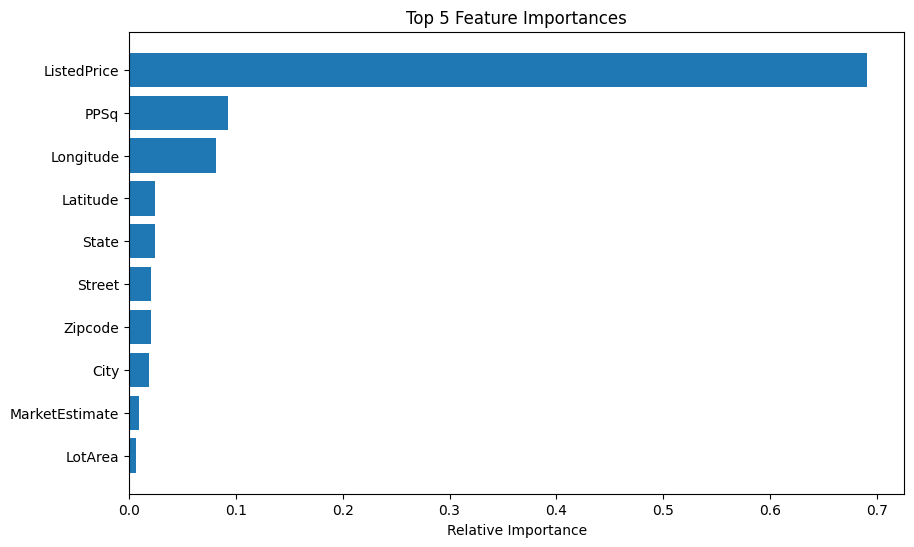

"[('LotArea', 0.006765128467539299), ('MarketEstimate', 0.008819884523145262), ('City', 0.018675403872991148), ('Zipcode', 0.020350222964635564), ('Street', 0.020370570738077087), ('State', 0.024074114152040395), ('Latitude', 0.024614860678606815), ('Longitude', 0.08117802053491154), ('PPSq', 0.09301744237217505), ('ListedPrice', 0.6910407438626124)]"

In [89]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = best_gbc.feature_importances_
features = X_train.columns

importance_dict = dict(zip(features, feature_importances))

categories = [
    "State",
    "Zipcode",
    "City",
    "Street",
]
aggregated_importances = {}
for cat in categories:
    cat_importance = sum(
        importance
        for feature, importance in importance_dict.items()
        if feature.startswith(cat)
    )
    aggregated_importances[cat] = cat_importance

importance_dict.update(aggregated_importances)

importance_dict = {
    feature: importance
    for feature, importance in importance_dict.items()
    if not any(feature.startswith(cat + "_") for cat in categories)
}

sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1])

top_features, top_importances = zip(*sorted_importances[-10:])

plt.figure(figsize=(10, 6))
plt.title("Top 5 Feature Importances")
plt.barh(range(len(top_features)), top_importances, align="center")
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Relative Importance")
plt.show()

f"{sorted_importances[-10:]}"